# RECOMMENDATION ENGINES - AMAZON TOYS AND GAMES

## GROUP C
- Nikolas Artadi
- Camila Vasquez
- Assemgul Khametova
- Miguel Frutos

## TASK
- **DATA SELECTION AND PRE-PROCESSING**(Mandatory)
First, you need to select a product category (from the “Small subsets for experiment”) and download the related file to create a training dataset and a testing dataset for the experiment. A recommended standard pre-processing strategy is that: each user randomly selects 80% of their ratings as the training ratings and uses the remaining 20% ratings as testing ratings.
- **COLLABORATIVE FILTERING RECOMMENDER SYSTEM** (Mandatory)
Based on the training dataset, you should develop a Collaborative Filtering model/algorithm to predict the ratings in the testing set. You may use any existing algorithm implemented in Surprise (or any other library) or develop new algorithms yourself. After predicting the ratings in the testing set, evaluate your predictions by calculating the RMSE.
- **CONTENT-BASED RECOMMENDER SYSTEM** (Mandatory)You should leverage the textual
information related to the reviews to create a Content-based RS to predict the ratings for the users in the test set. I do recommend you make use of the lab session related to the topic.
- **HYBRID HS**(Optional)
As an extra, you can propose a hybrid recommender system joining the operation of the two previously developed systems. To that end, you can make use of any of the ideas explained in class.
    
## DATASET
We follow the data set Toys and Games in the following [source](http://deepyeti.ucsd.edu/jianmo/amazon/index.html).

### Ratings only features explanation
- **reviewerID/user-id** - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- **asin/product-id** - ID of the product, e.g. 0000013714
- **reviewerName** - name of the reviewer
- **helpful/helpfulness** - helpfulness rating of the review, e.g. 2/3 [#users that think this review is not helpful,
#users that think this review is helpful]
- **reviewText/review** - text of the review
- **overall/rating** - rating of the product
- **summary/title** - summary of the review
- **unixReviewTime/timestamp** - time of the review (unix time)
- **reviewTime** - time of the review (raw)
    
### Product Metadata set
- **asin** - ID of the product, e.g. 0000031852
- **title** - name of the product
- **feature** - bullet-point format features of the product
- **description** - description of the product
- **price** - price in US dollars (at time of crawl)
- **imageURL** - url of the product image
- **imageURL** - url of the high resolution product image
- **related** - related products (also bought, also viewed, bought together, buy after viewing)
- **salesRank** - sales rank information
- **brand** - brand name
- **categories** - list of categories the product belongs to
- **tech1** - the first technical detail table of the product
- **tech2** - the second technical detail table of the product
- **similar** - similar product table

# LET´S GET STARTED

 ## LIBRARIES INSTALATION

In [58]:
# ! pip install scikit-surprise
# ! pip install plotly
# ! pip install seaborn

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

from surprise import SVDpp
from surprise import SVD
from surprise import KNNBaseline
from surprise import SVDpp
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import SlopeOne




from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt

## READ DATA

In [59]:
# df = pd.read_json('game_toy.json',lines=True)

# Ratings data
ratings_game_toy = pd.read_json('game_toy.json',lines=True)

# Games and Toys description
meta_game_toy = pd.read_json('meta_Toys_and_Games.json',lines=True)

# Merge both datasets together to facilitate their use
df = pd.merge(df, meta_game_toy, on='asin', how='inner')


# Split dataset into training (df) and test dataset at 80% for training of the total data
df, test_dataset = train_test_split(df, train_size=0.80,random_state=42)

# test_dataset.to_json('test_dataset.json')

## ANALYZE THE DATA

Take a quick look at the data to check if the dataset is correctly uploaded and to understand the variable´s content and the schema.

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134077 entries, 103644 to 121958
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   reviewerID        134077 non-null  object
 1   asin              134077 non-null  object
 2   helpful           134077 non-null  object
 3   reviewText        134077 non-null  object
 4   overall           134077 non-null  int64 
 5   summary           134077 non-null  object
 6   unixReviewTime    134077 non-null  int64 
 7   reviewTime        134077 non-null  object
 8   users_nothelpful  134077 non-null  int64 
 9   users_helpful     134077 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 11.3+ MB


In [61]:
df.describe()
# We can see that the ratings have min of 1 and max of 5

,overall,unixReviewTime
count,134077.000000,1.340770e+05
mean,4.356668,1.348671e+09
std,0.992509,6.100840e+07
min,1.000000,9.647424e+08
25%,4.000000,1.335658e+09
50%,5.000000,1.364342e+09
75%,5.000000,1.388016e+09
max,5.000000,1.406074e+09


In [62]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
103644,A9XX8OHS2ZQ2X,B00508OLNY,R. Neil Scott,"[3, 4]",I received this puzzle for review through the ...,4,Does not Dissapoint,1345420800,"08 20, 2012"
119165,AX8ATTTB67KFM,B00767PSIO,Lita Counts,"[1, 2]",I ordered this for my sons 1st bithday. It wa...,5,good party scene,1342396800,"07 16, 2012"
117593,A1VWK2BNL8I93C,B006X415GK,Theresa Mead,"[0, 0]",I bought this doll for my daughter. She enjoy...,4,Grated deal,1357862400,"01 11, 2013"
131341,A1AJWJGB89GSIL,B008A2BA90,R. Huffman,"[0, 1]",I initially picked this game up due to many gl...,4,A SEASONS for all magicians,1374192000,"07 19, 2013"
94465,A3KOL1FYRGZPGQ,B004NIF5OQ,SL,"[0, 0]",We bought my son the train set for Christmas a...,5,My son loves it!,1357430400,"01 6, 2013"
...,...,...,...,...,...,...,...,...,...
119879,AG2IEP1MJQHFS,B007ADICI2,Kelly Houser,"[0, 2]",Ravensburger puzzles are absolutely the best j...,5,Great value and great fun!,1341532800,"07 6, 2012"
103694,A3OBP99ZV5TG6C,B00508OOSG,Jay,"[0, 0]",The quality of the pieces was excellent. No m...,5,Excellent Puzzle - not for beginners,1342396800,"07 16, 2012"
131932,A3JR8YFXZQQBU0,B008B68IE0,emd104,"[1, 1]",Her arms and legs are so stiff they don't bend...,3,Beautiful doll...but...,1387929600,"12 25, 2013"
146867,A7N541YZQZIXH,B00BDMNBMI,ttim12,"[0, 0]",The plastic in the drum area doesn't sound gre...,4,My 12 month old likes it,1379980800,"09 24, 2013"


We have included an EDA and have identified duplicates and missing data which we will handle in the next steps.

In [63]:
def missing_values_percentage(df):
    """Return the % of missing values for each pd.series inside the Dataframe"""
    for i in df:
        missing_values_percentage = 100*df.isnull().sum()/df.isnull().count()
    return (missing_values_percentage[missing_values_percentage > 0]) 

In [64]:
missing_values_percentage(df)

reviewerName    0.504188
dtype: float64

In [109]:
#Count Reviewers´s number of evaluation
df.value_counts('reviewerID')

reviewerID
AJGU56YG8G1DQ     433
A1II2ZRPKZAQQD    141
A1M8AYAL3L8ACP    138
A2WW57XX2UVLM6    122
A1POFVVXUZR3IQ    103
                 ... 
A2B1OG9FQ9R3XS      1
A2S2PW6ESHF2H5      1
AOE9VPUNEZ847       1
A3CSZ21UC682CA      1
A148F4ZOSD82OW      1
Length: 19407, dtype: int64

In [65]:
#Decided to drop column review name as we have a 50% of missing values and the adding value of this column is zero.
del df['reviewerName']

In [66]:
missing_values_percentage(df)

Series([], dtype: float64)

In [67]:
#Drop duplicates
df.drop_duplicates
#Result, zero entire duplicated rows in game_toy dataset

<bound method DataFrame.drop_duplicates of             reviewerID        asin helpful  \
103644   A9XX8OHS2ZQ2X  B00508OLNY  [3, 4]   
119165   AX8ATTTB67KFM  B00767PSIO  [1, 2]   
117593  A1VWK2BNL8I93C  B006X415GK  [0, 0]   
131341  A1AJWJGB89GSIL  B008A2BA90  [0, 1]   
94465   A3KOL1FYRGZPGQ  B004NIF5OQ  [0, 0]   
...                ...         ...     ...   
119879   AG2IEP1MJQHFS  B007ADICI2  [0, 2]   
103694  A3OBP99ZV5TG6C  B00508OOSG  [0, 0]   
131932  A3JR8YFXZQQBU0  B008B68IE0  [1, 1]   
146867   A7N541YZQZIXH  B00BDMNBMI  [0, 0]   
121958   ASGGVJI9IOZAA  B007HZ9S7C  [0, 0]   

                                               reviewText  overall  \
103644  I received this puzzle for review through the ...        4   
119165  I ordered this for my sons 1st bithday.  It wa...        5   
117593  I bought this doll for my daughter.  She enjoy...        4   
131341  I initially picked this game up due to many gl...        4   
94465   We bought my son the train set for Christmas a

In [68]:
df.sort_values("helpful", ascending=False).head(5)

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
46315,A1OUQCTNVKPVR9,B0010VS078,"[1589, 1637]",I loaned my iPod to my kid and he broke it. T...,4,It's a great portable music solution,1270166400,"04 2, 2010"
103098,A4LD7XC56J3ZV,B004Z7H07K,"[1431, 1502]",Hi! I am Erin T. and I run a website called th...,5,My Son Won't Put it Down,1313712000,"08 19, 2011"
131030,A1SC7Z2646QCP9,B0089RPUHO,"[1413, 1449]",If you want a child-friendly tablet-style devi...,5,Hands down the best choice for a child-friendl...,1350864000,"10 22, 2012"
22121,ASGI7E0AJ8H5X,B0006O8Q7Y,"[1247, 1258]","Prior to purchasing, I searched all over to tr...",5,ultra stomp rocket vs junior stomp rocket,1231718400,"01 12, 2009"
39168,A1GALZCXD8FHOR,B000NOU54O,"[988, 1018]",Let's cut to the chase: If you're looking for ...,4,Hard to beat its total value in a beginner mic...,1200355200,"01 15, 2008"


## FEATURE EXTRACTION

This is a core step for the Content-based RS to identify similar contents and the creation of user profiles. <br>
The "helpful" feature covers the evaluation of the review by other potential customers (splited in not helpful and helful). To increase the readiness of the model through the data, we will separate it into 2 different columns.

In [69]:
df['users_nothelpful']=df.helpful.str[0]
df['users_helpful']=df.helpful.str[1]

# Analyze the data

### See the count of ratings per rating

In [70]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# Count the number of times each rating appears in the dataset
data = df['overall'].value_counts().sort_index(ascending=False)

# Create the histogram
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} Toys and Games Ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Most of the reviews are at 5, this shows an extremely skewed graph and therefore we can infer that the ratings given in this data set are strongly biased as most lay between 4 and 5. We have over 80% of users rating positively the product.

### See the number ratings per product

In [71]:
# Number of ratings per game_toy
data = df.groupby('asin')['overall'].count()

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'overall',
                     xbins = dict(start = 0,size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Product',
                   xaxis = dict(title = 'Number of Ratings Per Product ID'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can clearly see a long tail of reviews per product. Only almost 50 products have most of the total reviews and the rest have extremely low reviews.

### See the number of ratings per users

In [72]:
# Number of ratings per user
data = df.groupby('reviewerID')['overall'].count()
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0, size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In this segement, the similar scenario happened as in the previous case. We see a high distribution among a small amount of users and an extremely long tail among the latter ones.

We can now savely remove those users that fall below our threshhold of at least 50 reviews.

In [73]:
# Removing those users that have a rating below the threshhold

tresh = 50
sub_df = df[df.groupby('reviewerID')['overall'].transform('count')>tresh].copy() 
print('Old shape: ',df.shape[0],'rows')
print('New shape: ',sub_df.shape[0],'rows')
print('Difference: ',-df.shape[0]+sub_df.shape[0],'rows')

Old shape:  134077 rows
New shape:  4952 rows
Difference:  -129125 rows


# Start of the collaborative filtering RS

In [74]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader)

### 1. KNN

In [75]:
# # To use item-based cosine similarity
# sim_options = {
#     "name": "cosine",
#     "user_based": False,  # Compute  similarities between items
# }
# knn = KNNBaseline(sim_options=sim_options)

In [76]:
sim_options = {'name':'pearson_baseline'}

knn = KNNBaseline(k=40,min_k=2,sim_options=sim_options,verbose=True)

results = cross_validate(knn,data,measures=['RMSE','MAE'],cv=5,verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9184  0.9163  0.9048  0.9129  0.9082  0.9121  0.0050  
MAE (testset)     0.6961  0.6923  0.6849  0.6902  0.6871  0.6902  0.0039  
Fit time          27.41   26.91   27.20   29.76   27.92   27.84   1.02    
Test time         2.68    1.43    1.05    1.11    1.1

The RMSE is almost 91 with slights variations. Which shows a stable results over the 5 folds.

In [77]:
cross_validate(NormalPredictor(), data, measures=['RMSE'], cv=3, verbose=True)

Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2728  1.2737  1.2728  1.2731  0.0004  
Fit time          0.16    0.19    0.19    0.18    0.02    
Test time         0.36    1.07    0.32    0.58    0.34    


{'test_rmse': array([1.27275385, 1.27369296, 1.27281467]),
 'fit_time': (0.15880680084228516, 0.19075489044189453, 0.19202303886413574),
 'test_time': (0.36128830909729004, 1.0689258575439453, 0.32475709915161133)}

We can understand that KNN is learning from the dataset given. At this point almost 1.27 is the threshold for all the whole dataset.

Tuning the KNN

In [78]:
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNBaseline, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

The best configuration corresponds to a item-based configuration using Mean Square distance with a min support equals to 5, which is able to slightly reduce the RMSE to 0.92. Which is similar to the first baseline we ran with KNN.

### 2. Matrix Factorization

In [79]:
from surprise import SVDpp

# We'll use the famous SVD algorithm.
svd = SVDpp()

results = cross_validate(svd, data, measures=['RMSE'], cv=3, verbose=False)

### 3. Benchmarking

## Basic algorithms

* With the Surprise library, we will benchmark the following algorithms

#### NormalPredictor

* NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

#### BaselineOnly

* BasiclineOnly algorithm predicts the baseline estimate for given user and item.

## k-NN algorithms

#### KNNBasic

* KNNBasic is a basic collaborative filtering algorithm.

#### KNNWithMeans

* KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

#### KNNWithZScore

* KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

#### KNNBaseline

* KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

## Matrix Factorization-based algorithms

#### SVD

* SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)

#### SVDpp

* The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

#### NMF

* NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

### Slope One

* Slope One is a straightforward implementation of the SlopeOne algorithm. (https://arxiv.org/abs/cs/0702144)

### Co-clustering

* Co-clustering is a collaborative filtering algorithm based on co-clustering (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf)

Source: https://colab.research.google.com/github/singhsidhukuldeep/Recommendation-System/blob/master/Building_Recommender_System_with_Surprise.ipynb#scrollTo=1BKNsZL_6ttL

In [80]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(),KNNBasic(),KNNWithMeans(),KNNWithZScore(),SlopeOne(), BaselineOnly(), CoClustering()]:
    
    print("Testing {}".format(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
        

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Testing <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7feb422d46a0>
Testing <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7feb1e6dea90>
Testing <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7feaeb9e4190>
Testing <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7feaeb9b92e0>
Testing <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7feb1e65ad60>
Testing <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7feae3e686a0>
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Testing <surprise.prediction_algorithms.knns.KNNBasic object at 0x7feb1e4f2970>
Computing the msd similarity matrix...
Done computing similarity matrix

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.908906,19.004583,1.218055
SVD,0.914575,6.311981,0.354023
BaselineOnly,0.916123,0.385289,0.240727
KNNBaseline,0.968565,17.751627,1.691036
CoClustering,1.016105,5.039443,0.558980
KNNBasic,1.033184,17.756707,2.080961
KNNWithMeans,1.040921,16.490257,1.494642
KNNWithZScore,1.046800,20.119236,2.293878
SlopeOne,1.068494,4.804827,0.606939


SVDpp does take the longest to fit the model but has the best performance. In this case, there is only a somewhat better performance than SVD and the Baseline and depending on how fast we want customer to be influenced by the recommendation we can select a fast model like SVD or even an easy one like BaselineOnly. It has a fast test time and is not too far away as the rest of the results.

In [81]:
df

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,users_nothelpful,users_helpful
103644,A9XX8OHS2ZQ2X,B00508OLNY,"[3, 4]",I received this puzzle for review through the ...,4,Does not Dissapoint,1345420800,"08 20, 2012",3,4
119165,AX8ATTTB67KFM,B00767PSIO,"[1, 2]",I ordered this for my sons 1st bithday. It wa...,5,good party scene,1342396800,"07 16, 2012",1,2
117593,A1VWK2BNL8I93C,B006X415GK,"[0, 0]",I bought this doll for my daughter. She enjoy...,4,Grated deal,1357862400,"01 11, 2013",0,0
131341,A1AJWJGB89GSIL,B008A2BA90,"[0, 1]",I initially picked this game up due to many gl...,4,A SEASONS for all magicians,1374192000,"07 19, 2013",0,1
94465,A3KOL1FYRGZPGQ,B004NIF5OQ,"[0, 0]",We bought my son the train set for Christmas a...,5,My son loves it!,1357430400,"01 6, 2013",0,0
...,...,...,...,...,...,...,...,...,...,...
119879,AG2IEP1MJQHFS,B007ADICI2,"[0, 2]",Ravensburger puzzles are absolutely the best j...,5,Great value and great fun!,1341532800,"07 6, 2012",0,2
103694,A3OBP99ZV5TG6C,B00508OOSG,"[0, 0]",The quality of the pieces was excellent. No m...,5,Excellent Puzzle - not for beginners,1342396800,"07 16, 2012",0,0
131932,A3JR8YFXZQQBU0,B008B68IE0,"[1, 1]",Her arms and legs are so stiff they don't bend...,3,Beautiful doll...but...,1387929600,"12 25, 2013",1,1
146867,A7N541YZQZIXH,B00BDMNBMI,"[0, 0]",The plastic in the drum area doesn't sound gre...,4,My 12 month old likes it,1379980800,"09 24, 2013",0,0


## Try out the solution

In [82]:
# Execute KNN
sim_options = {'name': 'pearson_baseline', 'user_based': False}
knn = KNNBaseline(sim_options=sim_options)
knn.fit(data.build_full_trainset())

# Target game_toy to analyze its neighbourhood
game_name = 'B007HZ9S7C'

# Get the closes neighbourds
neighbors = knn.get_neighbors(knn.trainset.to_inner_iid(game_name), k=10)
# Translate the internal ids used in the algorithm to the game_toy names
neighbors = (knn.trainset.to_raw_iid(inner_id) for inner_id in neighbors)

print()
print('The 10 nearest neighbors of {} are:\n'.format(game_name))
for game in neighbors:
    print("\t",game)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

The 10 nearest neighbors of B007HZ9S7C are:

	 B007J3FAJ2
	 B0085UA8ZO
	 B0039X6XZG
	 B001W09LO8
	 B007Z8U7CG
	 B00BD9BXBM
	 B004ORV2O8
	 B004UCBU6M
	 B004ORWXFA
	 B00BFREGZ2


Is not really usefull at first sight, we can only define the product once we get the related product type. Nonetheless, we can pass this to our servers and make a join to define what to recommend to our users.

## Analyze bias

> Best games

In [84]:
game_name = [(b, data.build_full_trainset().to_raw_iid(i)) for i, b in enumerate(svd.bi)]
print("Best games:")
sorted(game_name, key=lambda x: x[0])[:15]

KeyboardInterrupt: 

> Worst games

In [ ]:
print("Worst games:")
sorted(game_name, key=lambda x: -x[0])[:15]

### User bias

In [ ]:
user_bias = [(b, train.to_raw_uid(i)) for i, b in enumerate(svd.bu)]
sorted(user_bias, key=lambda x: x[0])[0]

In [ ]:
df[df.userID == 'reviewerID']

In [ ]:
sorted(user_bias, key=lambda x: x[0])[-1]

In [ ]:
df[df.userID == 'reviewerID']

## Analyze Factors
- The multivariate variance can be largely explained by a smaller number of underlying clusters (factors) where each factor consists of multiple variables.
- FA uses the correlations between multiple variables to sort related variables into clusters that we call "factors". 
- Factors are nor easily interpretable (even for small datasets).
- PCA is a common-way to reduce dimensionality of the factor matrix.(Trail/error exercise).

In [85]:
svd.qi

array([[ 0.16581813,  0.03692871,  0.07255995, ..., -0.08317558,
        -0.04733463, -0.0838554 ],
       [ 0.10708184, -0.0209843 , -0.02496809, ..., -0.01315754,
        -0.01480915, -0.01614108],
       [ 0.07394258,  0.14790747,  0.05955419, ...,  0.1802928 ,
         0.11936726, -0.01714928],
       ...,
       [ 0.06056232,  0.10055002,  0.09131638, ..., -0.03641609,
        -0.02127502,  0.05064327],
       [ 0.11369859, -0.16611465,  0.12592128, ...,  0.02702437,
         0.00796807, -0.02803201],
       [-0.02184883,  0.00269989,  0.15861173, ..., -0.12340092,
        -0.0206487 , -0.05496617]])

In [86]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(svd.qi)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [87]:
for row in principalDf.sort_values(by='principal component 1', ascending=False).head(10).iterrows():
    print("Game_Toy: {} with PC value = {}".format(trainset.to_raw_iid(row[0]), row[1][0]))

NameError: name 'trainset' is not defined

In [88]:
for row in principalDf.sort_values(by='principal component 2', ascending=False).head(10).iterrows():
    print("Game_Toy: {} with PC value = {}".format(trainset.to_raw_iid(row[0]), row[1][1]))

NameError: name 'trainset' is not defined

In [89]:
for row in principalDf.sort_values(by='principal component 3', ascending=False).head(10).iterrows():
    print("Game_Toy: {} with PC value = {}".format(trainset.to_raw_iid(row[0]), row[1][2]))

NameError: name 'trainset' is not defined

NameError: name 'trainset' is not defined

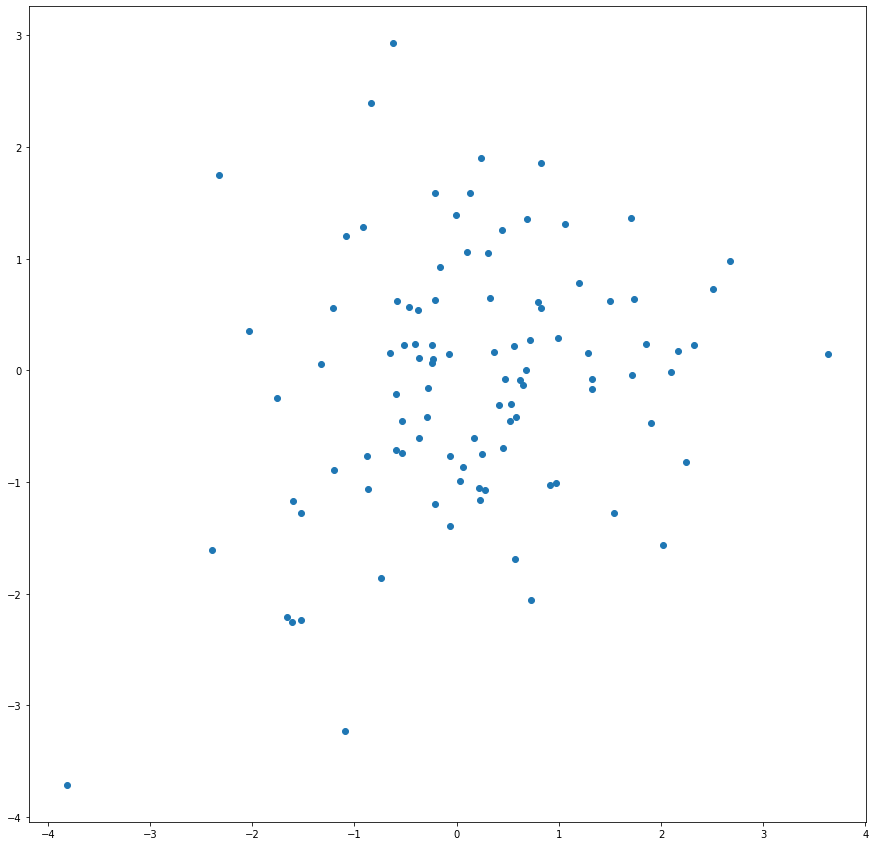

In [90]:


# Taking randomly just 100 games or toys to avoid overcrowding the plot
idxs = np.random.choice(len(principalDf), 100, replace=False) 
idxs = list(range(100))

# Represent the game_toys according to the principal components
X = principalDf.iloc[idxs]['principal component 1'].values
Y = principalDf.iloc[idxs]['principal component 2'].values

# Plot the game_toys
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip([trainset.to_raw_iid(idx) for idx in idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# CONTENT BASED - Textual Features

### FEATURE EXTRACTION

In [ ]:
#Every category is separated by a "," so we simply have to call the split function on |
df['category'] = df.str.split(',')

#Copying the game_toy dataframe into a new one since we won't need to use the category information in our first case.
game_toysWithCat = df.copy()

#For every row in the dataframe, iterate through the list of category and place a 1 into the corresponding column
for index, row in meta_game_toy.iterrows():
    for category in row['categories']:
        game_toysWithCat.at[index, category] = 1
        
#Filling in the NaN values with 0 to show that a game_toy doesn't have that column's category
game_toysWithCat = game_toysWithCat.fillna(0)
game_toysWithCat.head()

### USER PROFILE GENERATION

In [93]:
user_id = AJGU56YG8G1DQ #Reviewer with most evaluations

# Get from the ratings dataframe only the rows (ratings) related to the user_id
user_rating = ratings_game_toy[ratings_game_toy.reviewerID == user_id]
user_rating.drop("timestamp", 1)

# Merge with the game_toy dataframe to add the game_toy description to facilitate the analysis of the results
inputgame_toy = pd.merge(user_rating, meta_game_toy, on='asin')['asin', 'overall', 'description']
inputgame_toy

In [ ]:
#Filtering out the game_toy from the input
usergame_toy = game_toysWithcat[game_toysWithcat['asin'].isin(inputgame_toy['asin'].tolist())]
usergame_toy

In [ ]:
#Resetting the index to avoid future issues
usergame_toy = usergame_toy.reset_index(drop=True)
#Dropping unnecessary issues due to save memory and to avoid issues
userCatTable = usergame_toy.drop('asin', 1).drop('description', 1).drop('category', 1)
userCatTable

In [ ]:
#Dot produt to get weights
userProfile = userCatTable.transpose().dot(inputgame_toy['overall'])
userProfile

In [ ]:
#Now let's get the categories of every game_toy in our original dataframe
CatTable = game_toysWithcat.set_index(game_toysWithcat['asin'])
#And drop the unnecessary information
CatTable = CatTable.drop('asin', 1).drop('description', 1).drop('category', 1)
CatTable.head(10) #This is for all games and toys

In [ ]:
#Multiply the categories by the weights and then take the weighted average
recommendationTable_df = ((CatTable*userProfile).sum(axis=1))/(userProfile.sum())

#Sort our recommendations in descending order
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)

recommendationTable_df

In [ ]:
recommendationTable_df.drop(inputgame_toy.asin, inplace=True)

### CREATING A TF-IDF VECTORIZER

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(ds['description'])

In [ ]:
feature_names = tfidf.get_feature_names()
df = pd.DataFrame(tfidf_matrix.todense(), columns=feature_names)
df

In [ ]:
dict(df.sort_values(by=1, ascending=False, axis=1).iloc[1])

### COSINE SIMILARITY

In [ ]:
from sklearn.metrics.pairwise import linear_kernel 

# Compute cosine similarity
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# Iterate over the items in the dataset to find the most similar ones to each one
results = {}
for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1] 
    similar_items = [(cosine_similarities[idx][i], ds['id'][i]) for i in similar_indices] 
    results[row['id']] = similar_items[1:]

In [ ]:
def item(id):  
    return ds.loc[ds['id'] == id]['description'].tolist()[0].split(' - ')[0] 

# Just reads the results out of the dictionary
def recommend(item_id, num):
    print("Recommending " + str(num) + " products similar to " + item(item_id) + "...")   
    print("-------")
    recs = results[item_id][:num]   
    for rec in recs: 
        print("Recommended: " + item(rec[1]) + " (score:" +      str(rec[0]) + ")")

In [ ]:
recommend(item_id=11, num=5)

#### NIKO CODE

In [ ]:
from sklearn.metrics.pairwise import linear_kernel 
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
df['feedback'] = df['summary'] + " - " + df['reviewText']

In [ ]:
text_filtering = df[['asin','feedback']]

# Choosing a smaller size, otherwise the Kernel breaks in creating the dictionary with the scores
text_filtering = text_filtering.iloc[:500]

text_filtering

In [ ]:
tfidf = TfidfVectorizer(analyzer='word', min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(text_filtering['feedback'])

In [ ]:
feature_names = tfidf.get_feature_names()
ndf = pd.DataFrame(tfidf_matrix.todense(), columns=feature_names)
ndf

In [ ]:
dict(ndf.sort_values(by=1, ascending=False, axis=1).iloc[1])

In [ ]:
# Compute cosine similarity
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# Iterate over the items in the dataset to find the most similar ones to each one
results = {}
for idx, row in text_filtering.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:0]
    similar_items = [(cosine_similarities[idx][i], text_filtering['asin'][i]) for i in similar_indices] 
    results[row['asin']] = similar_items[1:]

In [ ]:
def item(id):  
    return text_filtering.loc[text_filtering['asin'] == id]['feedback'].tolist()[0].split(' - ')[0] 

# Just reads the results out of the dictionary
def recommend(item_id, num):
    print("Recommending " + str(num) + " products similar to " + item(item_id) + "...")   
    print("-------")
    recs = results[item_id][:num]   
    for rec in recs: 
        print("Recommended: " + item(rec[1]) + " (score:" +      str(rec[0]) + ")")

In [ ]:
recommend(item_id=11, num=5)

# Conclusions